# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
from collections import OrderedDict, defaultdict
import dgl
from itertools import chain, islice, combinations
from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms.approximation import maximum_independent_set as mis
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

### Problem-specific (MIS) utilities

In [3]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Step 1 - Build correlation matrix

In [4]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

# drop columns with more than 60% NaN values
sp500_hist.dropna(axis=1, thresh=int(len(sp500_hist)*0.4), inplace=True)

# drop columns with negative values in it
sp500_hist.drop(
    columns=sp500_hist.columns[(sp500_hist < 0).any()].values, 
    axis=1,
    inplace=True)

# reduce dataset
# sp500_hist = sp500_hist.iloc[:,:n]

print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (4279, 484)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.439508,35.305668,38.559849,2.272182,NaN,16.348289,12.590348,6.120000,21.528095,38.520000,...,29.771492,9.832613,32.591091,24.051765,NaN,12.118679,60.463249,42.830002,58.061222,NaN
2006-01-04,20.494427,36.955471,38.834522,2.278869,NaN,16.239967,12.609449,6.151111,21.645647,38.419998,...,29.716309,9.880271,32.646824,24.274343,NaN,12.222367,61.037167,42.410000,58.471172,NaN
2006-01-05,21.031340,37.436260,39.020573,2.260936,NaN,16.038809,12.771802,6.061111,21.807291,38.070000,...,29.539726,9.874971,32.485168,23.998352,NaN,12.743404,60.392624,42.529999,59.002590,NaN
2006-01-06,21.141167,36.766926,38.976273,2.319297,NaN,15.860854,13.016929,6.173333,22.887375,39.000000,...,29.821157,9.912039,33.126179,24.372272,NaN,12.707114,60.083572,44.119999,59.617485,NaN
2006-01-09,21.080151,36.399242,39.481319,2.311697,NaN,15.860854,13.500801,6.116667,22.821247,38.380001,...,31.228340,9.885561,33.109463,24.612658,NaN,12.805617,62.211487,44.790001,59.124062,NaN


In [5]:
METHOD = 'pct'

if METHOD == 'standard':
    df_corr = sp500_hist.corr(method='pearson').abs()
elif METHOD == 'pct':
    sp500_pct = sp500_hist.pct_change()
    sp500_pct = sp500_pct.groupby(sp500_pct.index.year).sum()
    df_corr = sp500_pct.corr(method='pearson').abs()
else:
    raise KeyError("METHOD must be either 'standard' or 'pct'")

df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.060148,0.157241,0.768849,0.296156,0.650578,0.280147,0.065514,0.525189,0.790364,...,0.663047,0.471917,0.115992,0.529148,0.344200,0.557185,0.697162,0.603583,0.371461,0.250599
AAL,0.060148,1.000000,0.224094,0.215877,0.164439,0.274348,0.071334,0.097154,0.294366,0.025244,...,0.136421,0.057326,0.076684,0.035960,0.131628,0.089025,0.251139,0.095523,0.689320,0.051941
AAP,0.157241,0.224094,1.000000,0.165893,0.082694,0.154293,0.043957,0.207145,0.259158,0.164824,...,0.131879,0.061767,0.195827,0.045652,0.028089,0.217367,0.085204,0.624863,0.294638,0.308580
AAPL,0.768849,0.215877,0.165893,1.000000,0.003183,0.427384,0.358726,0.077663,0.506498,0.652120,...,0.574399,0.493280,0.225341,0.760153,0.207377,0.590832,0.523787,0.606444,0.032689,0.338361
ABBV,0.296156,0.164439,0.082694,0.003183,1.000000,0.438390,0.375691,0.005438,0.133962,0.328067,...,0.171925,0.139648,0.085694,0.013000,0.737339,0.013464,0.284705,0.219766,0.231086,0.287347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.557185,0.089025,0.217367,0.590832,0.013464,0.143048,0.306183,0.011620,0.482253,0.336445,...,0.609360,0.244276,0.057292,0.453082,0.186298,1.000000,0.051380,0.438750,0.356881,0.203073
ZBH,0.697162,0.251139,0.085204,0.523787,0.284705,0.569873,0.224853,0.292309,0.355824,0.682151,...,0.624609,0.645481,0.126241,0.508549,0.354637,0.051380,1.000000,0.356322,0.205201,0.126459
ZBRA,0.603583,0.095523,0.624863,0.606444,0.219766,0.221410,0.511447,0.230220,0.685547,0.754664,...,0.187514,0.382681,0.501544,0.435461,0.520876,0.438750,0.356322,1.000000,0.397458,0.798334
ZION,0.371461,0.689320,0.294638,0.032689,0.231086,0.245172,0.112833,0.364542,0.521887,0.176920,...,0.348359,0.152980,0.070638,0.138350,0.411440,0.356881,0.205201,0.397458,1.000000,0.294993


In [6]:
df_corr.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,...,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,0.506297,0.223431,0.210457,0.446698,0.227388,0.381237,0.267273,0.199907,0.448440,0.454357,...,0.395910,0.339142,0.228000,0.429103,0.310935,0.336834,0.427163,0.426707,0.323515,0.314372
std,0.236545,0.172122,0.141183,0.226584,0.153475,0.183304,0.169582,0.161656,0.213368,0.223387,...,0.202376,0.179704,0.173747,0.200260,0.191752,0.181676,0.209262,0.200708,0.182889,0.202766
min,0.002699,0.000118,0.000088,0.003183,0.001336,0.005008,0.000293,0.000129,0.001045,0.003342,...,0.000290,0.000016,0.000259,0.001705,0.000269,0.000073,0.006582,0.002556,0.001881,0.000978
25%,0.302443,0.090328,0.099535,0.269340,0.107051,0.248484,0.129812,0.073419,0.276665,0.285438,...,0.227385,0.211902,0.087841,0.291272,0.154237,0.197280,0.273821,0.284115,0.186960,0.150149
50%,0.535351,0.181212,0.201765,0.435520,0.208785,0.394875,0.242091,0.164115,0.473584,0.485860,...,0.402103,0.357807,0.196977,0.449676,0.289118,0.325834,0.449232,0.452322,0.318251,0.293004
75%,0.703073,0.336138,0.296703,0.636013,0.331365,0.518713,0.381456,0.286818,0.618283,0.639060,...,0.555242,0.469281,0.327914,0.590836,0.453651,0.470022,0.597282,0.577199,0.442642,0.448560
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df_corr.quantile(0.5).mean()

0.3612086905103364

In [8]:
stock_names = df_corr.columns.values

# Step 3 - Generate Graph

In [9]:
def build_nx_graph(df_corr:pd.DataFrame, threshold:float) -> nx.Graph:
    """ Returns a Networkx.Graph from a correlation matrix.
        Args:
            df_corr (pd.DataFrame): Correlation matrix
            threshold (float): edges with an correlation coefficient smaller
                than the treshold will be removed. 
                Note: The treshold bust be choosen reasonalbe, the graph must
                not be disconnected.
        Returns:
            nx.Graph
    """
    cor_matrix = df_corr.values.astype('float')
    sim_matrix = 1 - cor_matrix
    G = nx.from_numpy_array(sim_matrix)

    stock_names = df_corr.index.values
    # G = nx.relabel_nodes(G, lambda x: stock_names[x])
    # G.edges(data=True)
    H = G.copy()

    for (u, v, wt) in G.edges.data('weight'):

        if wt >= 1 - threshold:
            H.remove_edge(u, v)

        if u == v:
            H.remove_edge(u, v)

    return H

In [10]:
nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=0.5
)

assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'

In [11]:
assert (df_corr.where(df_corr >= 0.5).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

Average degree: 133.31


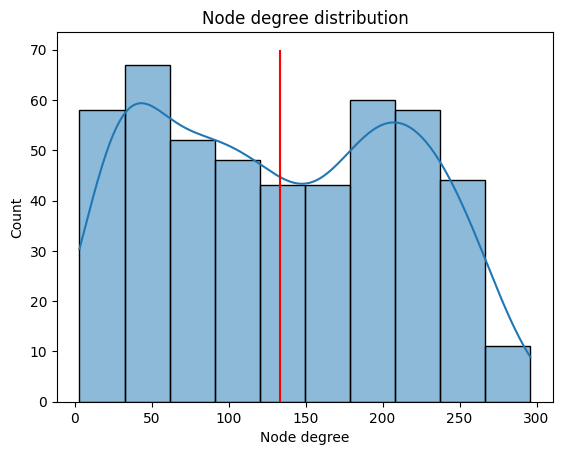

In [12]:
degrees = [degree for (node, degree) in nx_graph.degree()]
avg_degree = sum(degrees) / len(degrees)
print(f"Average degree: {avg_degree:.2f}")

sns.histplot(degrees, kde=True)
plt.vlines(avg_degree, ymin=0, ymax=70, colors=['r'])
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.show()

In [13]:
# Constructs a random d-regular or p-probabilistic graph
# nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

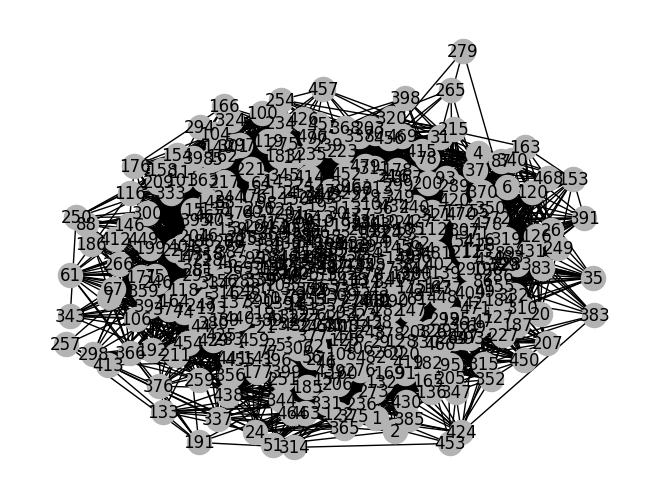

In [14]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [15]:
# Establish pytorch GNN + optimizer
n = len(nx_graph.nodes)

params = {
    'lr': 1e-4,
    'dim_embedding': int(np.sqrt(n)),
    'hidden_dim': int(np.sqrt(n) / 2),
    'dropout': 0.05,
    'number_classes': 1,
    'prob_threshold': 0.5,
    'number_epochs': 50_000,
    'tolerance': 1e-4  ,
    'patience': 100,
    'model': "SAGE_2L_Model",
}

params

{'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 50000,
 'tolerance': 0.0001,
 'patience': 100,
 'model': 'SAGE_2L_Model'}

In [16]:
net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

# Step 4 - Run GNN training

In [17]:
print('Running GNN...')
gnn_start = time()

net, embed, optimizer = get_gnn(
    n_nodes=n, 
    params=params, 
    model_type=params["model"], 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)   
    
net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
    q_torch=q_torch, 
    dgl_graph=graph_dgl, 
    net=net, 
    embed=embed, 
    optimizer=optimizer, 
    number_epochs=params['number_epochs'],
    tol=params['tolerance'], 
    patience=params['patience'], 
    prob_threshold=params['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 64033.6875
Epoch: 1000, Loss: 19.937088012695312
Epoch: 2000, Loss: 18.607507705688477
Epoch: 3000, Loss: 4.0443596839904785
Epoch: 4000, Loss: -2.09635066986084
Epoch: 5000, Loss: -2.2800207138061523
Epoch: 6000, Loss: -1.9759637117385864
Epoch: 7000, Loss: -4.097211837768555
Epoch: 8000, Loss: -4.684311389923096
Epoch: 9000, Loss: -7.055395603179932
Epoch: 10000, Loss: -6.805310249328613
Epoch: 11000, Loss: -9.774945259094238
Epoch: 12000, Loss: -13.172890663146973
Epoch: 13000, Loss: -13.132143020629883
Epoch: 14000, Loss: -15.905335426330566
Epoch: 15000, Loss: -16.72545051574707
Epoch: 16000, Loss: -21.89642333984375
Epoch: 17000, Loss: -22.085865020751953
Epoch: 18000, Loss: -22.855899810791016
Epoch: 19000, Loss: -24.911893844604492
Epoch: 20000, Loss: -27.503597259521484
Epoch: 21000, Loss: -28.970869064331055
Epoch: 22000, Loss: -28.986658096313477
Epoch: 23000, Loss: -31.893159866333008
Epoch: 24000, Loss: -31.963237762451172
Epoch: 25000, Loss:

# Step 5 - Post-process GNN results

In [18]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis_gnn} with {number_violations_gnn} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 34 with 0 violations
Took 391.784s, model training took 391.634s


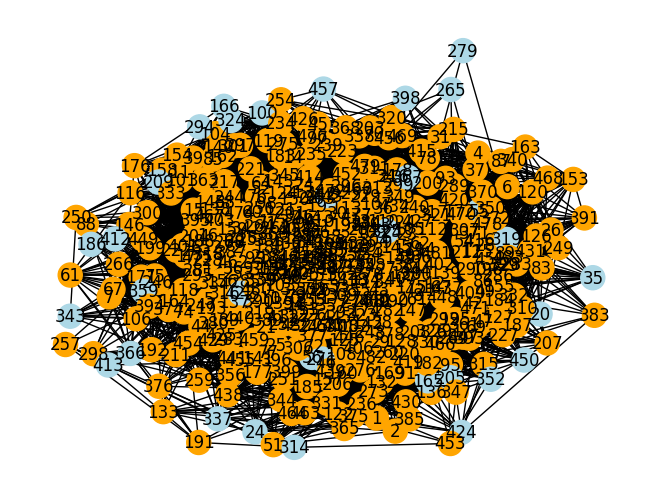

In [19]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

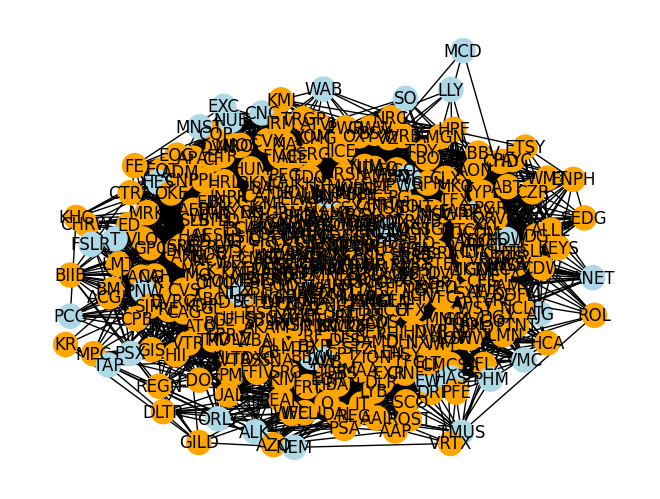

In [20]:
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph, lambda x: stock_names[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [21]:
# print(f"Assets in MIS:")
gnn_mis_set = stock_names[np.argwhere(best_bitstring == 1)].tolist()[0]

Assets in MIS:


# Step 6 - (optional) Compare to classical solver

In [22]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=484).
Calculating violations...
Independence number found by nx solver is 35 with 0 violations.
MIS solver took 4.794s


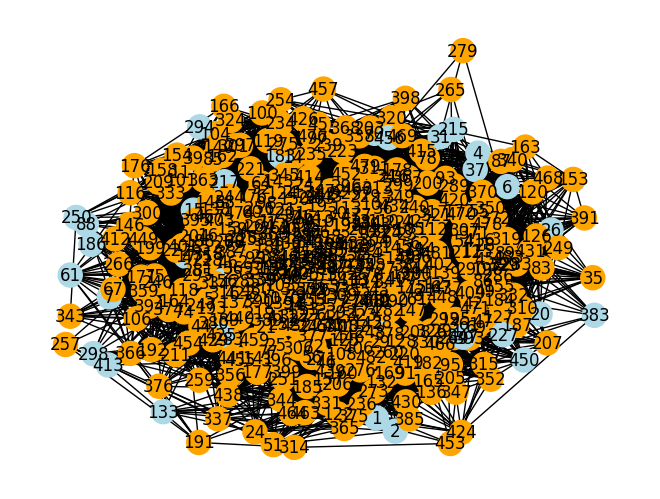

In [23]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

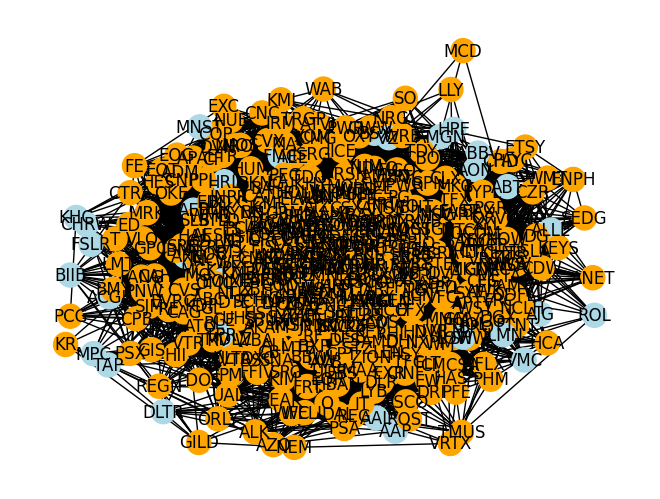

In [24]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [25]:
print(f"Assets in MIS:")
solver_mis_set = stock_names[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

Assets in MIS:


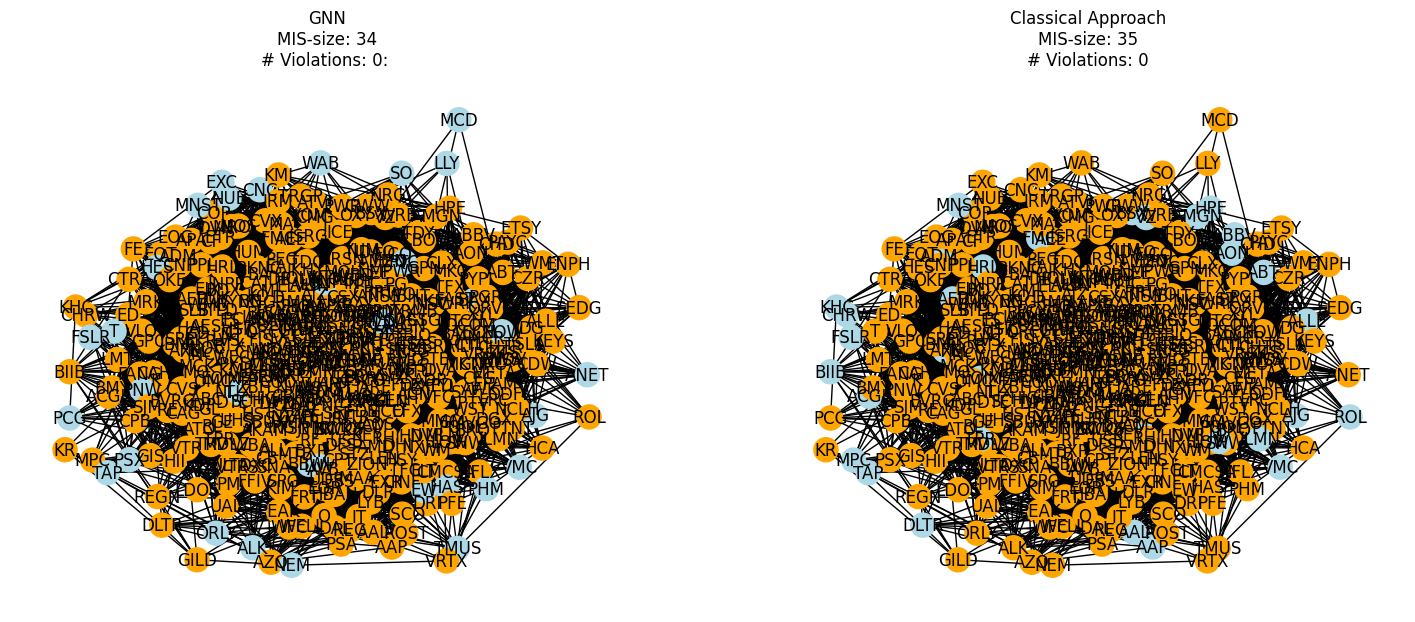

In [26]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# GNN
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax0)
ax0.set_title(f"GNN\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

In [27]:
df_mis = pd.concat([
    pd.DataFrame(
        data={'gnn': gnn_mis_set},
        index=gnn_mis_set
    ),
    pd.DataFrame(
        data={'solver': solver_mis_set},
        index=solver_mis_set
    )
],
axis=1)

df_mis

,gnn,solver
AJG,AJG,AJG
ALK,ALK,NaN
AMZN,AMZN,NaN
ANET,ANET,NaN
BAX,BAX,NaN
...,...,...
MPC,NaN,MPC
ROL,NaN,ROL
TPR,NaN,TPR
V,NaN,V


In [28]:
# intersection
df_intersec = df_mis.dropna(axis=0)
print(f"Length: {len(df_intersec)}")
df_intersec

Length: 5


,gnn,solver
AJG,AJG,AJG
FSLR,FSLR,FSLR
MNST,MNST,MNST
TAP,TAP,TAP
VMC,VMC,VMC


In [29]:
df_non_intersec = df_mis.drop(index=df_intersec.index)
print(f"Length: {len(df_non_intersec)}")
df_non_intersec

Length: 59


,gnn,solver
ALK,ALK,NaN
AMZN,AMZN,NaN
ANET,ANET,NaN
BAX,BAX,NaN
BBWI,BBWI,NaN
CNC,CNC,NaN
EW,EW,NaN
EXC,EXC,NaN
HAS,HAS,NaN
HES,HES,NaN
